# Modelos de Regresión Logística

### 1. y 2. Creación de variables dicotómicas (precio)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Cargar el dataset
df = pd.read_csv("../data/train_preprocessed.csv")

# Crear columna de categoría de precio según percentiles 33% y 66%
p33 = df['SalePrice'].quantile(0.33)
p66 = df['SalePrice'].quantile(0.66)

def clasificar_precio(precio):
    if precio <= p33:
        return 'economica'
    elif precio <= p66:
        return 'media'
    else:
        return 'cara'

df['categoria_precio'] = df['SalePrice'].apply(clasificar_precio)

# Variables dicotómicas
df['es_cara'] = (df['categoria_precio'] == 'cara').astype(int)
df['es_media'] = (df['categoria_precio'] == 'media').astype(int)
df['es_economica'] = (df['categoria_precio'] == 'economica').astype(int)

# Verificar
df[['SalePrice', 'categoria_precio', 'es_cara', 'es_media', 'es_economica']].head()

,SalePrice,categoria_precio,es_cara,es_media,es_economica
0,208500,cara,1,0,0
1,181500,media,0,1,0
2,223500,cara,1,0,0
3,140000,media,0,1,0
4,250000,cara,1,0,0


### 3. Predecir si una vivienda es cara

Accuracy promedio (cross-validation): 0.9118154139613367


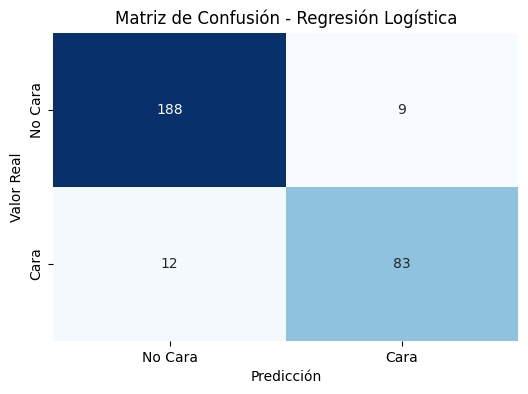


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       197
           1       0.90      0.87      0.89        95

    accuracy                           0.93       292
   macro avg       0.92      0.91      0.92       292
weighted avg       0.93      0.93      0.93       292



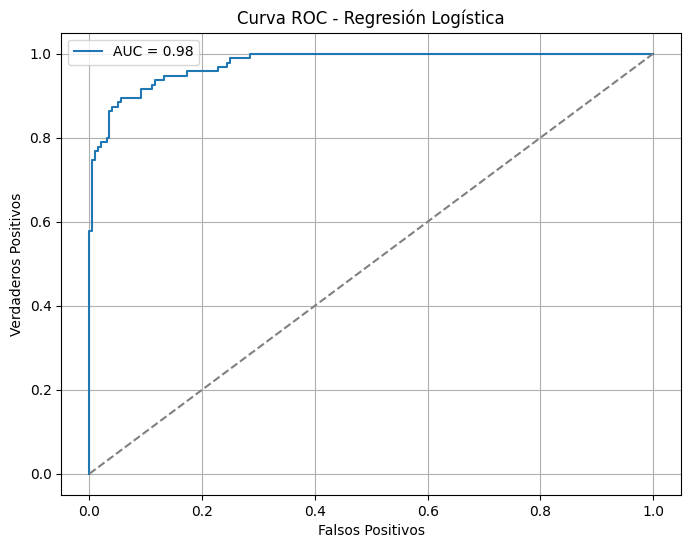

In [2]:
# Seleccionar las variables predictoras y la variable objetivo
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
target = 'es_cara'

# Dividir el dataset (80% entrenamiento, 20% prueba)
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo de regresión logística
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train_scaled, y_train)

# Validación cruzada
cv_scores = cross_val_score(log_model, X_train_scaled, y_train, cv=5)
print("Accuracy promedio (cross-validation):", cv_scores.mean())

# Predicciones en el conjunto de prueba
y_pred = log_model.predict(X_test_scaled)

# Matriz de confusión visual (heatmap)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Cara', 'Cara'], yticklabels=['No Cara', 'Cara'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

# Evaluación del modelo
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Curva ROC
y_prob = log_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend()
plt.grid()
plt.show()


###  4. Multicolinealidad, significancia y correlaciones

=== VIF de las variables predictoras ===
      Variable       VIF
0  OverallQual  2.445301
1    GrLivArea  2.474593
2   GarageCars  1.829365
3  TotalBsmtSF  1.556815
4     FullBath  2.099818
5    YearBuilt  2.065456
Optimization terminated successfully.
         Current function value: 0.249285
         Iterations 8

=== Resumen del modelo (statsmodels) ===
                           Logit Regression Results                           
Dep. Variable:                es_cara   No. Observations:                 1168
Model:                          Logit   Df Residuals:                     1161
Method:                           MLE   Df Model:                            6
Date:                Thu, 10 Apr 2025   Pseudo R-squ.:                  0.6128
Time:                        16:27:55   Log-Likelihood:                -291.16
converged:                       True   LL-Null:                       -751.92
Covariance Type:            nonrobust   LLR p-value:                8.394e-196
        

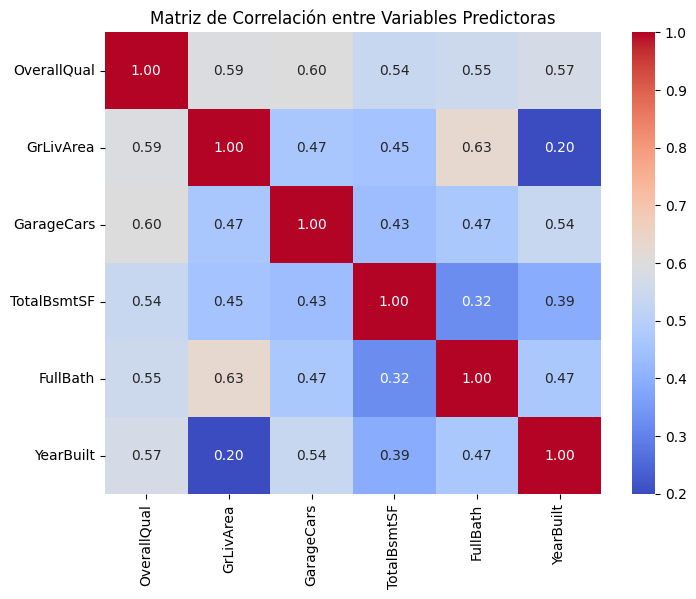

In [3]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular VIF para las variables predictoras
X_vif = pd.DataFrame(X_train_scaled, columns=features)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("=== VIF de las variables predictoras ===")
print(vif_data)

# Entrenar modelo con statsmodels para análisis de significancia
X_const = sm.add_constant(X_train_scaled)  # Agregar término constante (intercepto)
logit_model = sm.Logit(y_train, X_const)
result = logit_model.fit()

print("\n=== Resumen del modelo (statsmodels) ===")
print(result.summary())

# Visualizar matriz de correlación entre las variables predictoras
plt.figure(figsize=(8, 6))
sns.heatmap(X[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre Variables Predictoras')
plt.show()

### 5. Árbol de Decisión para predecir es_cara

=== Árbol de Decisión ===

Matriz de Confusión:


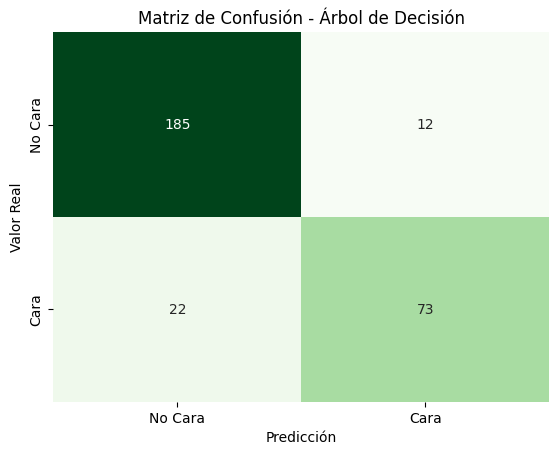


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       197
           1       0.86      0.77      0.81        95

    accuracy                           0.88       292
   macro avg       0.88      0.85      0.86       292
weighted avg       0.88      0.88      0.88       292



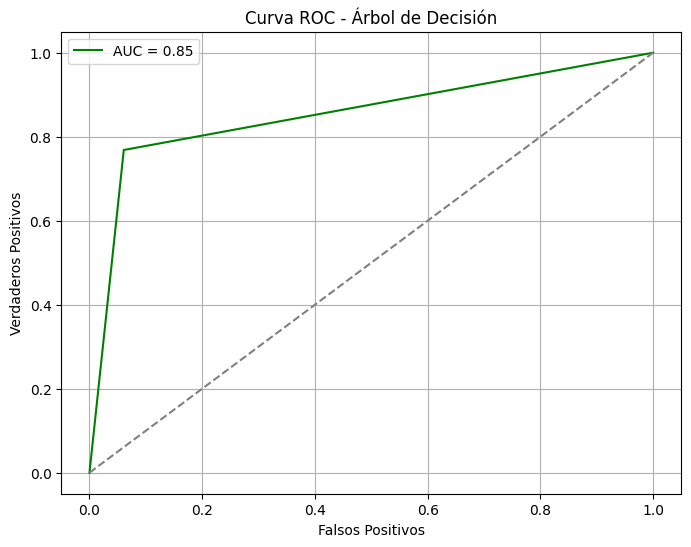

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Entrenar modelo de árbol de decisión
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Predicciones
y_pred_tree = tree_model.predict(X_test)

# Evaluación
print("=== Árbol de Decisión ===")
print("\nMatriz de Confusión:")
cm_tree = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Cara', 'Cara'], yticklabels=['No Cara', 'Cara'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_tree))

# Curva ROC
y_prob_tree = tree_model.predict_proba(X_test)[:, 1]
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
roc_auc_tree = roc_auc_score(y_test, y_prob_tree)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tree, tpr_tree, label=f'AUC = {roc_auc_tree:.2f}', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC - Árbol de Decisión')
plt.legend()
plt.grid()
plt.show()

### 6. Detección de sobreajuste y curvas de aprendizaje

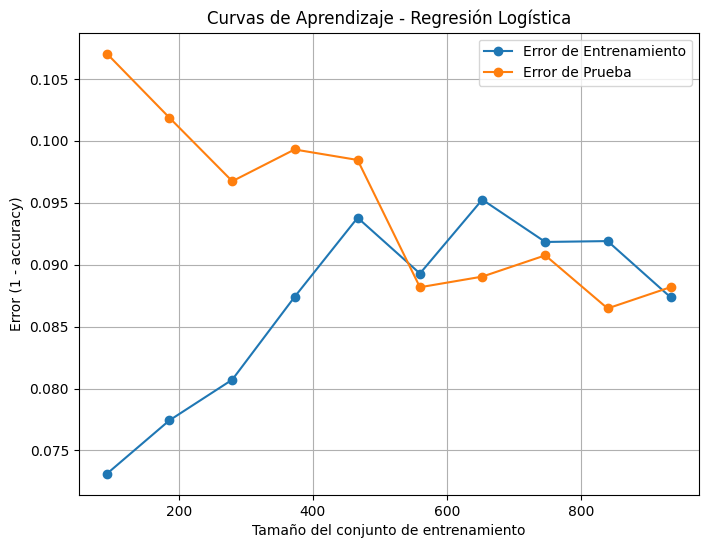

In [5]:
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

# Definir modelo
log_model = LogisticRegression(random_state=42, max_iter=1000)

# Calcular curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    estimator=log_model,
    X=X_train_scaled,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    shuffle=True,
    random_state=42
)

# Calcular errores (error = 1 - accuracy)
train_errors = 1 - train_scores.mean(axis=1)
test_errors = 1 - test_scores.mean(axis=1)

# Graficar curvas de aprendizaje
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_errors, label='Error de Entrenamiento', marker='o')
plt.plot(train_sizes, test_errors, label='Error de Prueba', marker='o')
plt.title('Curvas de Aprendizaje - Regresión Logística')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Error (1 - accuracy)')
plt.legend()
plt.grid()
plt.show()

### 7. Tuneo del modelo para determinar los mejores parámetros

Mejores parámetros encontrados:
{'C': 1, 'penalty': 'l1'}

Reporte de Clasificación del Mejor Modelo:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       197
           1       0.89      0.88      0.89        95

    accuracy                           0.93       292
   macro avg       0.92      0.92      0.92       292
weighted avg       0.93      0.93      0.93       292



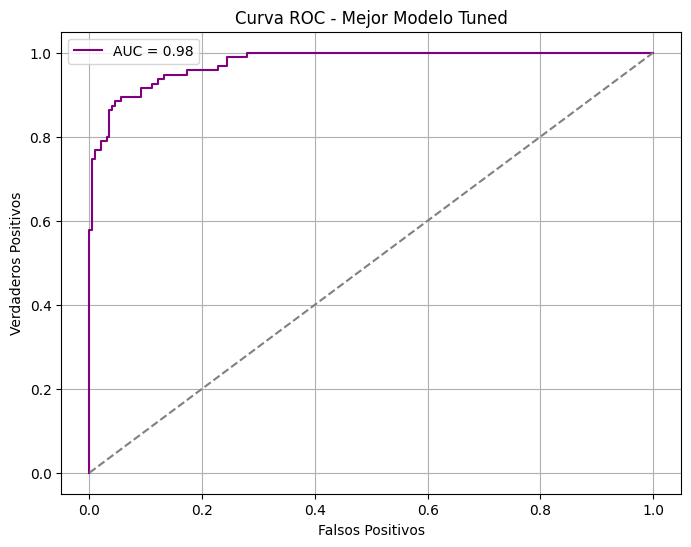

In [6]:
from sklearn.model_selection import GridSearchCV

# Definir el modelo base
log_model = LogisticRegression(solver='liblinear', max_iter=1000)

# Definir la grilla de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],              # fuerza de regularización (inversa)
    'penalty': ['l1', 'l2']                    # tipo de regularización
}

# Ejecutar GridSearch con validación cruzada
grid_search = GridSearchCV(estimator=log_model, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar al conjunto de entrenamiento
grid_search.fit(X_train_scaled, y_train)

# Mostrar mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el mejor modelo encontrado
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

print("\nReporte de Clasificación del Mejor Modelo:")
print(classification_report(y_test, y_pred_best))

# Curva ROC del mejor modelo
y_prob_best = best_model.predict_proba(X_test_scaled)[:, 1]
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
roc_auc_best = roc_auc_score(y_test, y_prob_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, label=f'AUC = {roc_auc_best:.2f}', color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Curva ROC - Mejor Modelo Tuned')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.legend()
plt.grid()
plt.show()


### 8. Evaluación de la eficiencia del modelo desde distintos ángulos

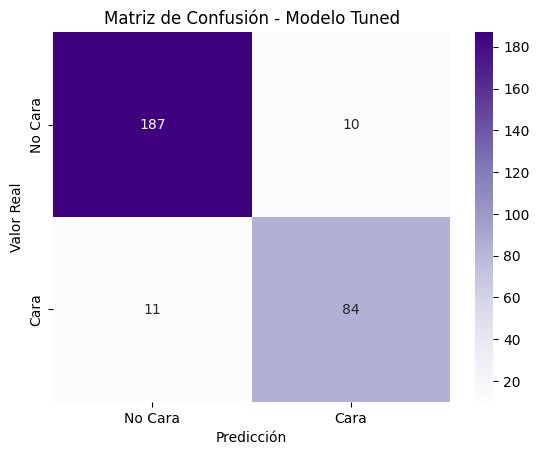

In [7]:
# Matriz de confusión del mejor modelo
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['No Cara', 'Cara'], yticklabels=['No Cara', 'Cara'])
plt.title('Matriz de Confusión - Modelo Tuned')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


In [9]:
import cProfile
import pstats
import io

# Definir una función que contenga todo el proceso
def evaluar_modelo():
    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))
    return y_pred

# Usar cProfile para analizar eficiencia
pr = cProfile.Profile()
pr.enable()
evaluar_modelo()
pr.disable()

# Mostrar resultados
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('cumtime')
ps.strip_dirs().print_stats(10)
print(s.getvalue())


              precision    recall  f1-score   support

           0       0.94      0.95      0.95       197
           1       0.89      0.88      0.89        95

    accuracy                           0.93       292
   macro avg       0.92      0.92      0.92       292
weighted avg       0.93      0.93      0.93       292

         17904 function calls (17815 primitive calls) in 0.019 seconds

   Random listing order was used
   List reduced from 455 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      182    0.000    0.000    0.000    0.000 warnings.py:503(__exit__)
        4    0.000    0.000    0.000    0.000 contextlib.py:104(__init__)
      182    0.000    0.000    0.000    0.000 warnings.py:456(__init__)
        1    0.000    0.000    0.000    0.000 threading.py:1153(_wait_for_tstate_lock)
      182    0.000    0.000    0.001    0.000 warnings.py:166(simplefilter)
        4    0.000    0.000    0.000    0.000 contextlib.py